In [42]:
import glob, os, json, mplhep as hep
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use(hep.style.CMS)
import hist
import hist.plot
from uncertainties import unumpy
import sys

In [5]:
data_dir = '/data_CMS/cms/vernazza/cmt/Categorization/ul_2018_ZZ_v12/'
stat_dir = '/data_CMS/cms/vernazza/cmt/MergeCategorizationStats/ul_2018_ZZ_v12/'

in_feat   = ['event', 
                'hh_kinfit_chi2', 'hh_kinfit_m', 'sv_mass', 'dR_l1_l2_x_sv_pT', 'l_1_mt', 'l_2_pT', 'dR_l1_l2',
                'dphi_sv_met', 'h_bb_mass', 'b_2_hhbtag', 'diH_mass_sv', 'dphi_hbb_sv', 'h_bb_pT', 
                'dR_l1_l2_boosted_htt_met', 'l_1_pT', 'b_1_pT', 'phi', 'costheta_l2_httmet', 
                'b_1_cvsb', 'b_1_cvsl', 'boosted', 'channel', 'is_vbf', 'jet_1_quality', 'jet_2_quality', 'year']
weights   = ['genWeight', 'puWeight', 'prescaleWeight', 'trigSF', 'L1PreFiringWeight_Nom', 'PUjetID_SF']

cont_feat = ['hh_kinfit_chi2', 'hh_kinfit_m', 'sv_mass', 'dR_l1_l2_x_sv_pT', 'l_1_mt', 'l_2_pT', 'dR_l1_l2',
                'dphi_sv_met', 'h_bb_mass', 'b_2_hhbtag', 'diH_mass_sv', 'dphi_hbb_sv', 'h_bb_pT', 
                'dR_l1_l2_boosted_htt_met', 'l_1_pT', 'b_1_pT', 'phi', 'costheta_l2_httmet', 'b_1_cvsb', 'b_1_cvsl']
cat_feat  = ['boosted', 'channel', 'is_vbf', 'jet_1_quality', 'jet_2_quality', 'year']

features = in_feat + weights

In [6]:
def read_root_file(filename, tree_name, features):
    root_file = uproot.open(filename)
    tree = root_file[tree_name]
    return tree.arrays(features, library="pd", filter_name=features + ["event"])

In [10]:
######################### Import imputs #########################

sig_sample = 'zz_sl_signal'
sig_XS = 5.52 * 0.046
files_sig = glob.glob(data_dir + sig_sample + '/cat_ZZ_elliptical_cut_90_sr/prod_240318/data_*.root')
print(" ### INFO: Reading signal samples for", sig_sample)
data_frames = [read_root_file(filename, 'Events', features) for filename in files_sig]
df_sig = pd.concat(data_frames, ignore_index=True)
stat_file = stat_dir + sig_sample + '_aux/prod_240305/stats.json'
with open(stat_file, "r") as f: 
    data = json.load(f)
    nevents = data['nevents']
    nweightedevents = data['nweightedevents']
df_sig['xs']         = sig_XS
df_sig['nev']        = nevents
df_sig['nev_w']      = nweightedevents
df_sig['gen_weight'] = df_sig['genWeight'] * df_sig['puWeight']
df_sig['cor_weight'] = df_sig['prescaleWeight'] * df_sig['trigSF'] * df_sig['L1PreFiringWeight_Nom'] * df_sig['PUjetID_SF']
df_sig['weight']     = sig_XS/nweightedevents * df_sig['gen_weight'] * df_sig['cor_weight']
df_sig['sample']     = sig_sample
del data_frames

bkg_samples_dict = { # TODO add DY PtZ
#   "zz_sl_signal": 5.52,
  "zz_sl_background": 5.52,
  "zh_hbb_zll": 0.052,
  "zh_htt": 0.0554,
  "wjets_ht1": 61526.7,
  "wjets_ht2": 1244.0,
  "wjets_ht3": 337.8,
  "wjets_ht4": 44.93,
  "wjets_ht5": 11.19,
  "wjets_ht6": 4.926,
  "wjets_ht7": 1.152,
  "wjets_ht8": 0.0002507,
  "dy_0j": 5090.0,
  "dy_1j": 983.5,
  "dy_2j": 353.6,
  "ewk_z": 6.215,
  "ewk_wplus": 39.05,
  "ewk_wminus": 32.05,
  "tt_dl": 88.29,
  "tt_sl": 365.34,
  "tt_fh": 377.96,
  "st_tw_antitop": 35.85,
  "st_tw_top": 35.85,
  "st_antitop": 80.95,
  "st_top": 136.02,
  "zz_dl": 1.26,
  "zz_fh": 3.262,
  "zz_lnu": 0.564,
  "zz_qnu": 4.07,
  "wz_lllnu": 4.43,
  "wz_lnuqq": 10.71,
  "wz_llqq": 5.595,
  "wz_lnununu": 3.414,
  "ww_llnunu": 12.178,
  "ww_lnuqq": 49.997,
  "ww_qqqq": 51.723,
  "zzz": 0.0147,
  "wzz": 0.057,
  "www": 0.209,
  "wwz": 0.168,
  "ttw_lnu": 0.2043,
  "ttw_qq": 0.4062,
  "ttww": 0.00698,
  "ttwz": 0.002441,
  "ttwh": 0.00158,
  "ttzh": 0.00154,
  "ttz_llnunu": 0.2529,
  "ttz_qq": 0.5297,
  "ttzz": 0.001386,
  "wminush_htt": 0.0334,
  "wplush_htt": 0.05268,
  "tth_bb": 0.2953,
  "tth_tautau": 0.031805,
  "ggH_ZZ": 28.87,
  "ggf_sm": 0.002268

}

df_all_bkg = pd.DataFrame()
for bkg_sample in bkg_samples_dict.keys():
    files_bkg = glob.glob(data_dir + bkg_sample + '/cat_ZZ_elliptical_cut_90_sr/prod_240318/data_*.root')
    # if '/data_CMS/cms/vernazza/cmt/PreprocessRDF/ul_2018_ZZ_v10_backup/wjets/cat_base_selection/prod_DNN_Ellipse80/data_2.root' in files_bkg:
    #     files_bkg.remove('/data_CMS/cms/vernazza/cmt/PreprocessRDF/ul_2018_ZZ_v10_backup/wjets/cat_base_selection/prod_DNN_Ellipse80/data_2.root')
    # if '/data_CMS/cms/vernazza/cmt/PreprocessRDF/ul_2018_ZZ_v10_backup/wjets/cat_base_selection/prod_DNN_Ellipse80/data_1.root' in files_bkg:
    #     files_bkg.remove('/data_CMS/cms/vernazza/cmt/PreprocessRDF/ul_2018_ZZ_v10_backup/wjets/cat_base_selection/prod_DNN_Ellipse80/data_1.root')
    print(" ### INFO: Reading background samples for", bkg_sample)
    data_frames = []
    for filename in files_bkg:
        try:
            data_frames.append(read_root_file(filename, 'Events', features))
        except uproot.KeyInFileError:
            pass # ignore empty files
    if len(data_frames) == 0:
        print("Skipping empty dataset " + bkg_sample)
        continue
    df_bkg = pd.concat(data_frames, ignore_index=True)
    stat_file = stat_dir + bkg_sample + '_aux/prod_240305/stats.json' #if bkg_sample != 'dy' else stat_dir + 'dy_nlo_aux/prod_230718/stats.json'
    with open(stat_file, "r") as f: 
        data = json.load(f)
        nevents = data['nevents']
        nweightedevents = data['nweightedevents']
    df_bkg['xs']         = bkg_samples_dict[bkg_sample]
    df_bkg['nev']        = nevents
    df_bkg['nev_w']      = nweightedevents
    df_bkg['gen_weight'] = df_bkg['genWeight'] * df_bkg['puWeight']
    df_bkg['cor_weight'] = df_bkg['prescaleWeight'] * df_bkg['trigSF'] *  df_bkg['PUjetID_SF']  # * df_bkg['DYstitchEasyWeight']
    df_bkg['weight']     = bkg_samples_dict[bkg_sample]/nweightedevents * df_bkg['gen_weight'] * df_bkg['cor_weight']
    df_bkg['sample']     = bkg_sample
    df_all_bkg = pd.concat([df_all_bkg, df_bkg], ignore_index=True)
    del data_frames

df_sig.insert(0, 'Class', 1, True)
df_all_bkg.insert(0, 'Class', 0, True)

 ### INFO: Reading signal samples for zz_sl_signal
 ### INFO: Reading background samples for zz_sl_background
 ### INFO: Reading background samples for zh_hbb_zll
 ### INFO: Reading background samples for zh_htt
 ### INFO: Reading background samples for wjets_ht1
 ### INFO: Reading background samples for wjets_ht2
 ### INFO: Reading background samples for wjets_ht3
 ### INFO: Reading background samples for wjets_ht4
 ### INFO: Reading background samples for wjets_ht5
 ### INFO: Reading background samples for wjets_ht6
 ### INFO: Reading background samples for wjets_ht7
 ### INFO: Reading background samples for wjets_ht8
 ### INFO: Reading background samples for dy_0j
 ### INFO: Reading background samples for dy_1j
 ### INFO: Reading background samples for dy_2j
 ### INFO: Reading background samples for ewk_z
 ### INFO: Reading background samples for ewk_wplus
 ### INFO: Reading background samples for ewk_wminus
 ### INFO: Reading background samples for tt_dl
 ### INFO: Reading backgrou

In [12]:
def normalize_weights(df:pd.DataFrame) -> None:
    df_copy = df.copy()
    print('Initial events sums', len(df_copy))
    print('Initial weight sums', df_copy['weight'].sum())
    df_copy['original_weight'] = df_copy['weight']
    df_copy['weight'] *= len(df_copy)/df_copy['original_weight'].sum()
    print('Final weight sums', df_copy['weight'].sum())
    return df_copy

df_sig_pos = df_sig[df_sig['weight'] >  0]
df_sig_neg = df_sig[df_sig['weight'] <= 0]
I_df_sig_pos = len(df_sig_pos)
I_df_sig_neg = len(df_sig_neg)
print(' ### Normalize positive histogram')
df_sig_pos_norm = normalize_weights(df_sig_pos)
print(' ### Normalize negative histogram')
df_sig_neg_norm = normalize_weights(df_sig_neg)

ratio = I_df_sig_neg/I_df_sig_pos
print(" ### Neg/Pos =", ratio)

 ### Normalize positive histogram
Initial events sums 10926
Initial weight sums 0.0031729453502934582
Final weight sums 10926.0
 ### Normalize negative histogram
Initial events sums 3261
Initial weight sums -0.0009263214176725533
Final weight sums 3260.9999999999995
 ### Neg/Pos = 0.2984623833058759


In [20]:
df_bkg_pos = df_all_bkg[df_all_bkg['weight'] >  0]
df_bkg_neg = df_all_bkg[df_all_bkg['weight'] <= 0]
I_df_bkg_pos = len(df_bkg_pos)
I_df_bkg_neg = len(df_bkg_neg)
print(' ### Normalize positive histogram')
df_bkg_pos_norm = normalize_weights(df_bkg_pos)
print(' ### Normalize negative histogram')
df_bkg_neg_norm = normalize_weights(df_bkg_neg)

ratio = I_df_bkg_neg/I_df_bkg_pos
print(" ### Neg/Pos =", ratio)

 ### Normalize positive histogram
Initial events sums 5306871
Initial weight sums 7.031560524479194
Final weight sums 5306871.000000003
 ### Normalize negative histogram
Initial events sums 208228
Initial weight sums -1.5471481098238151
Final weight sums 208227.99999999994
 ### Neg/Pos = 0.03923743388524047


In [51]:
len(vars)

24

/tmp/ipykernel_233347/236765210.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8,8))


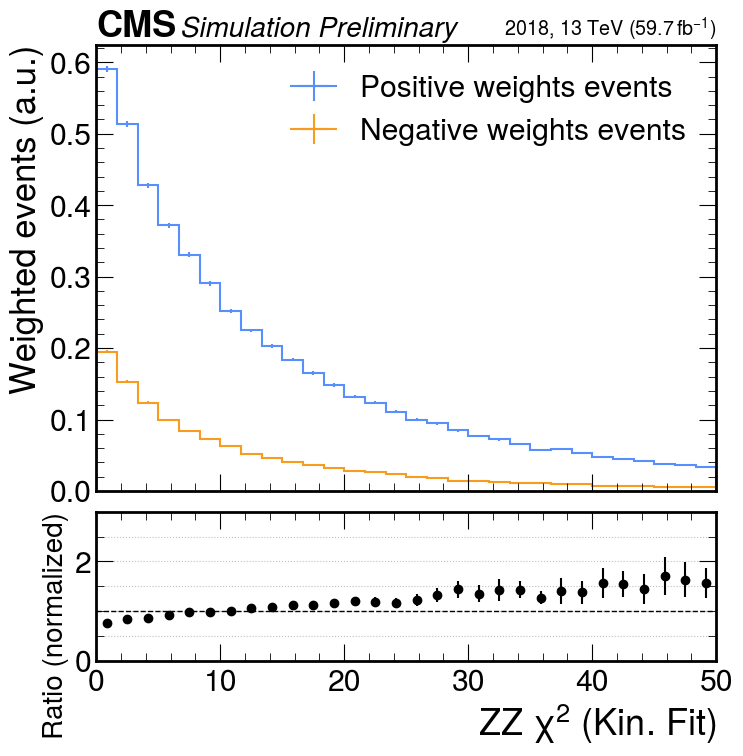

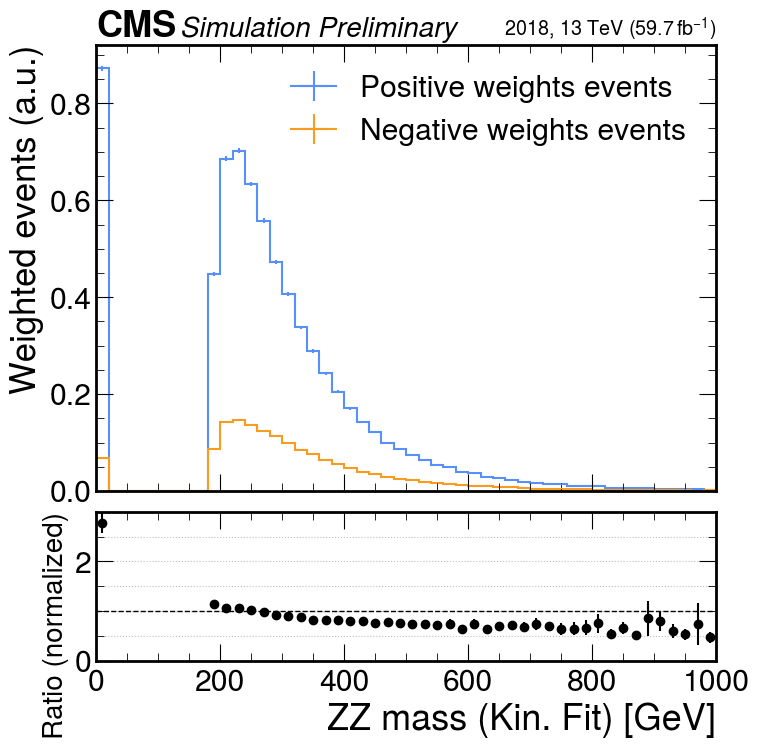

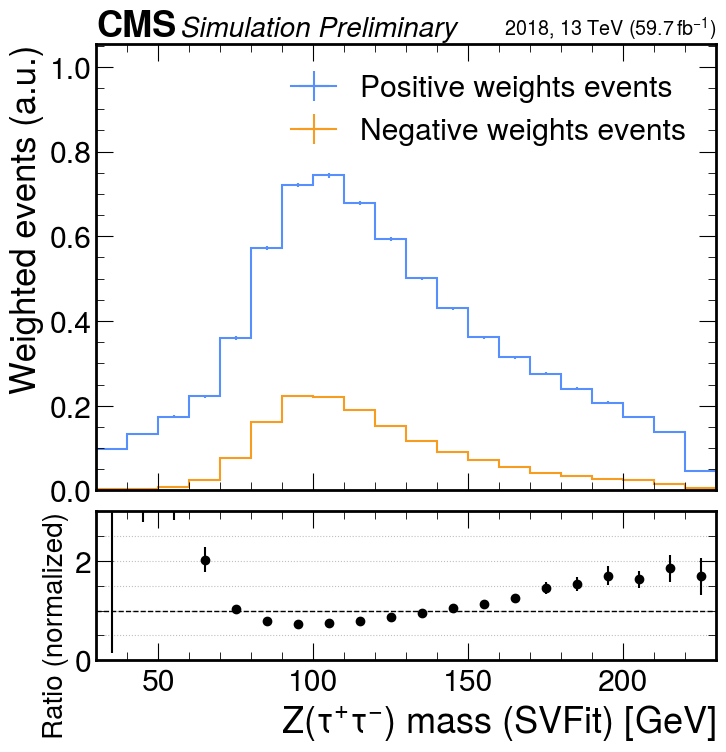

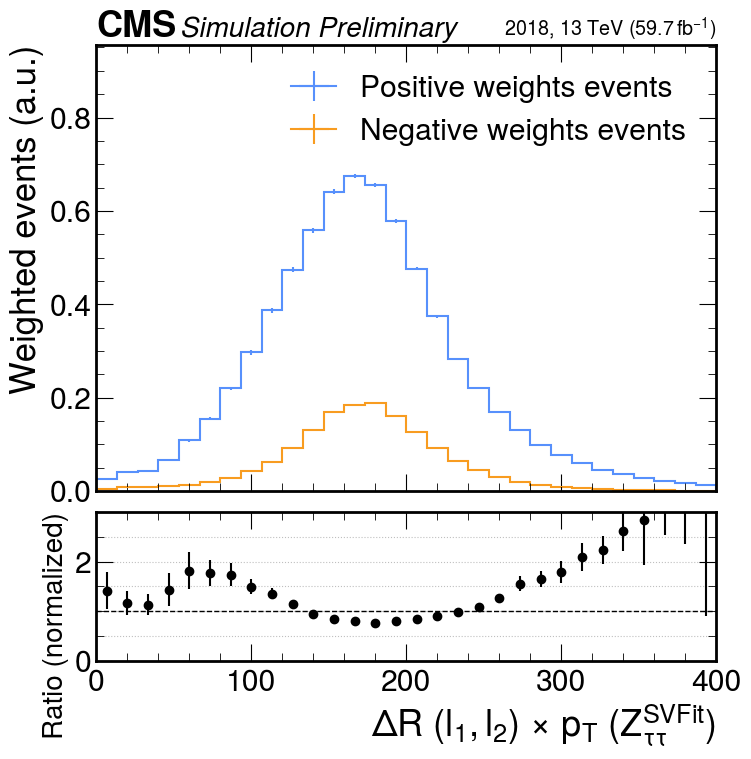

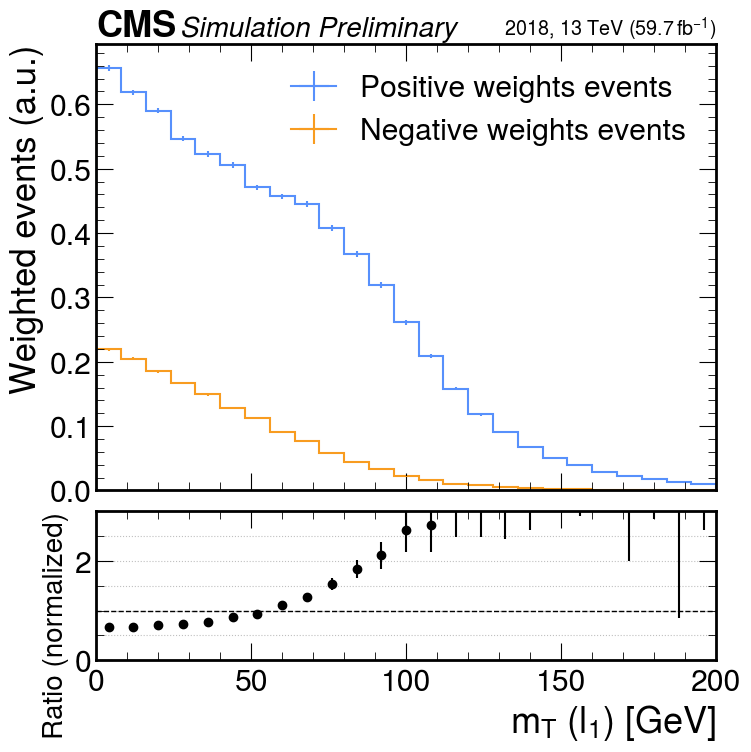

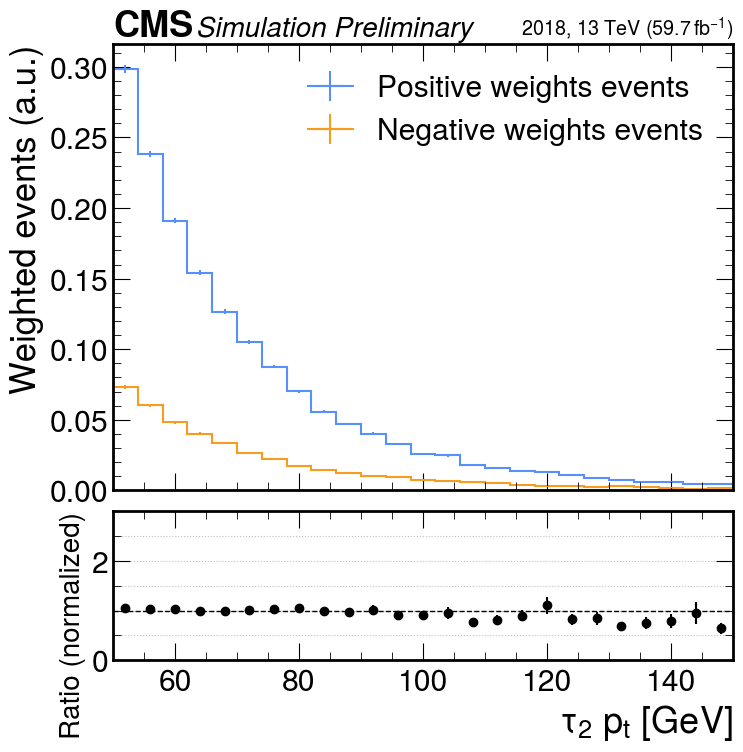

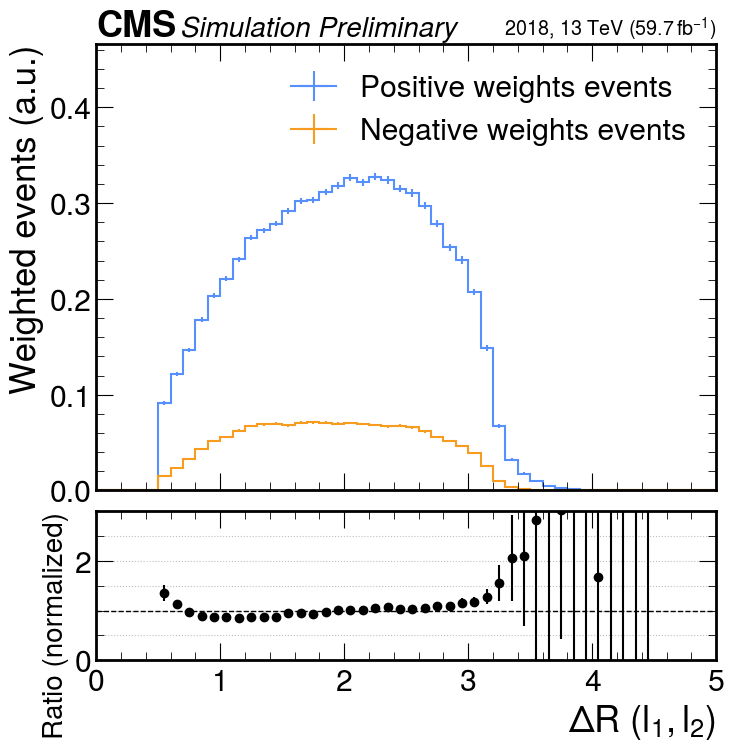

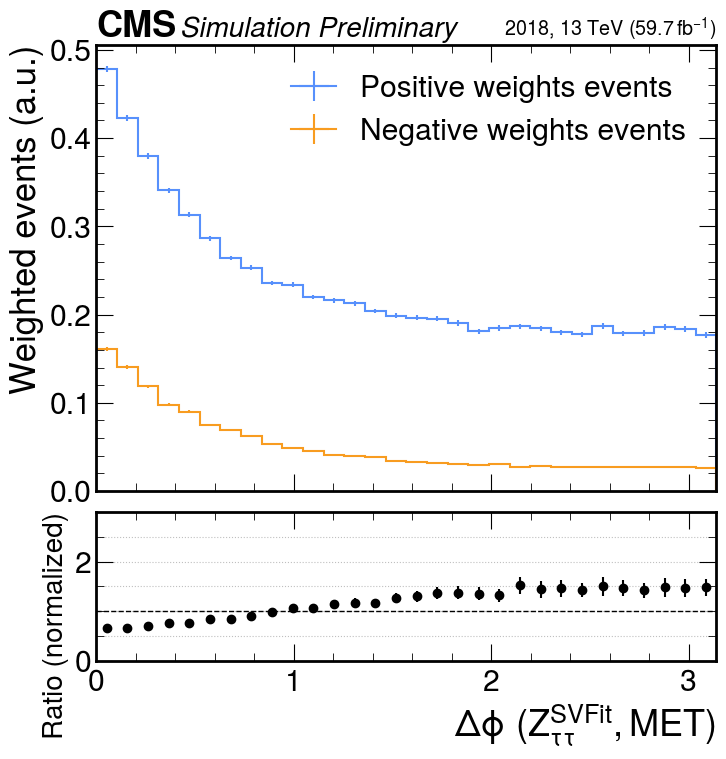

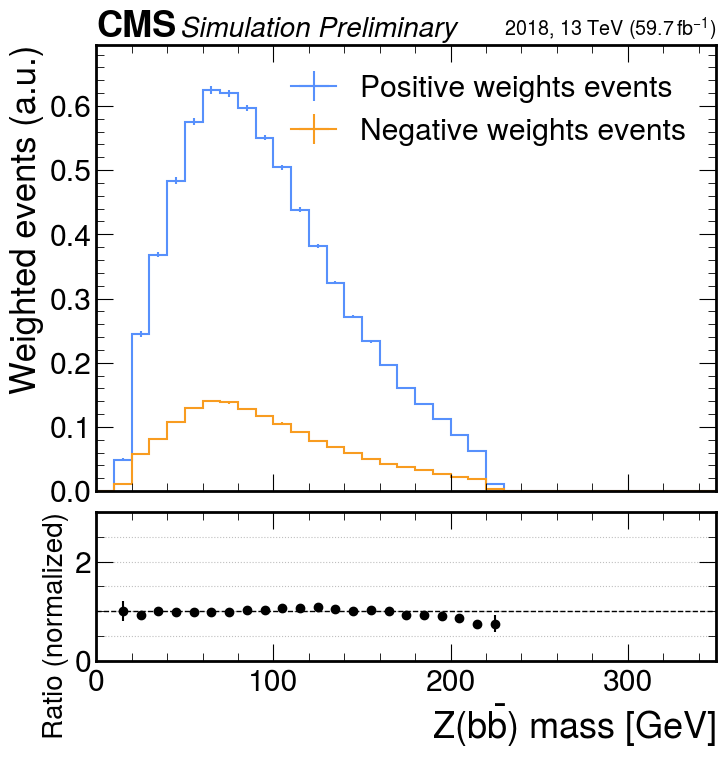

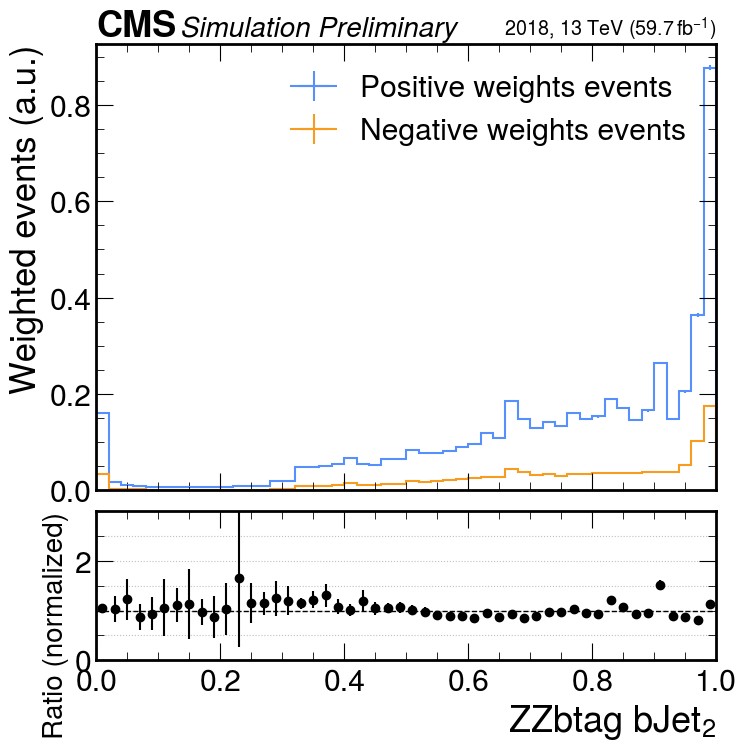

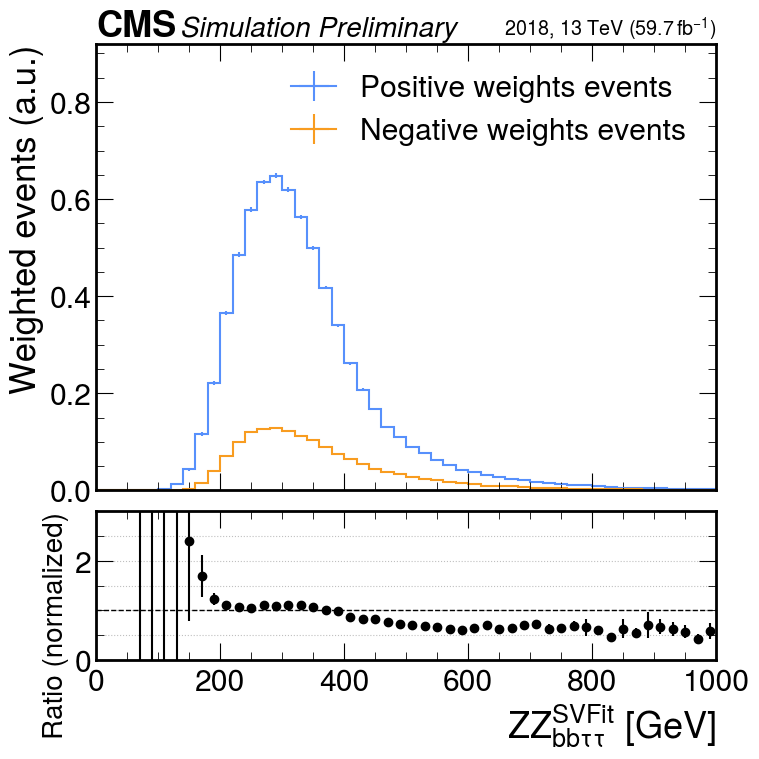

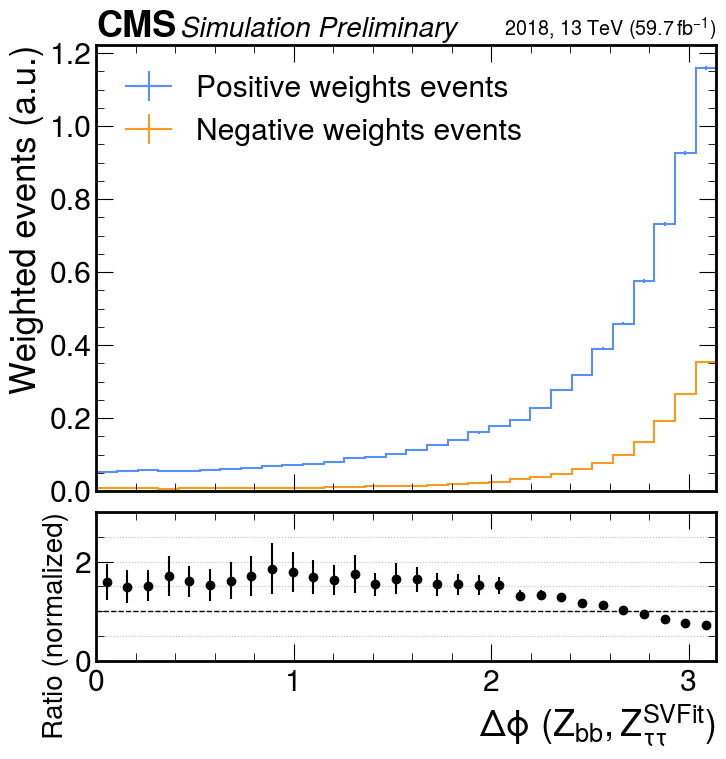

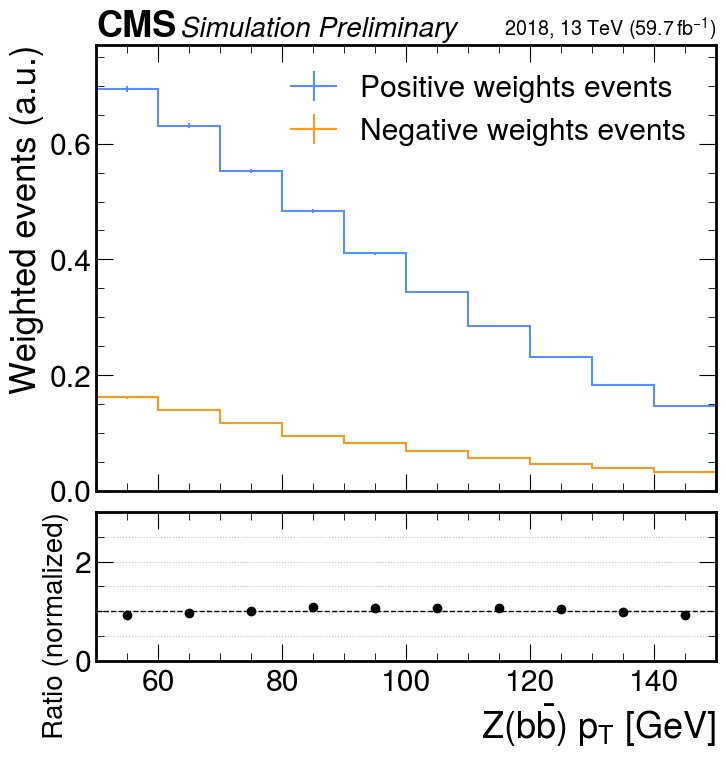

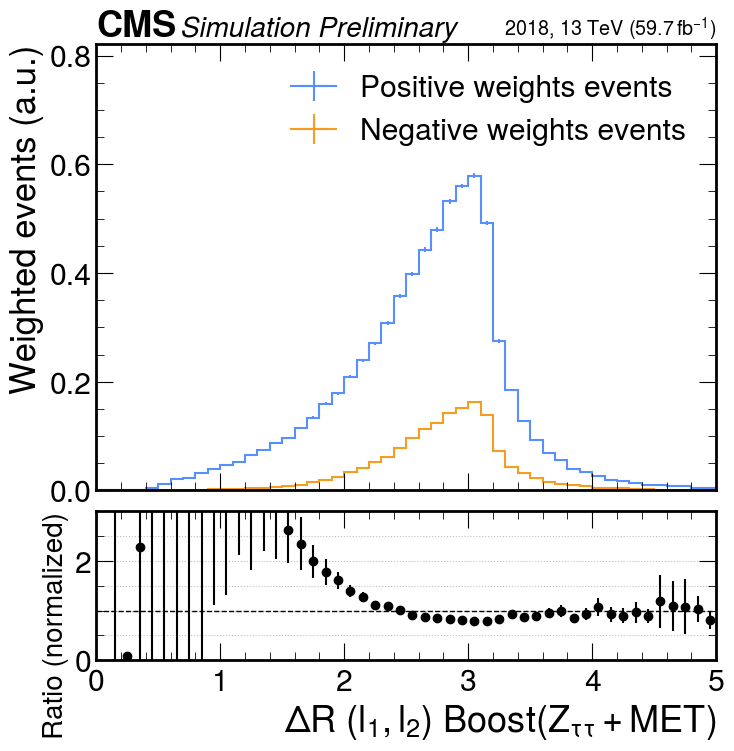

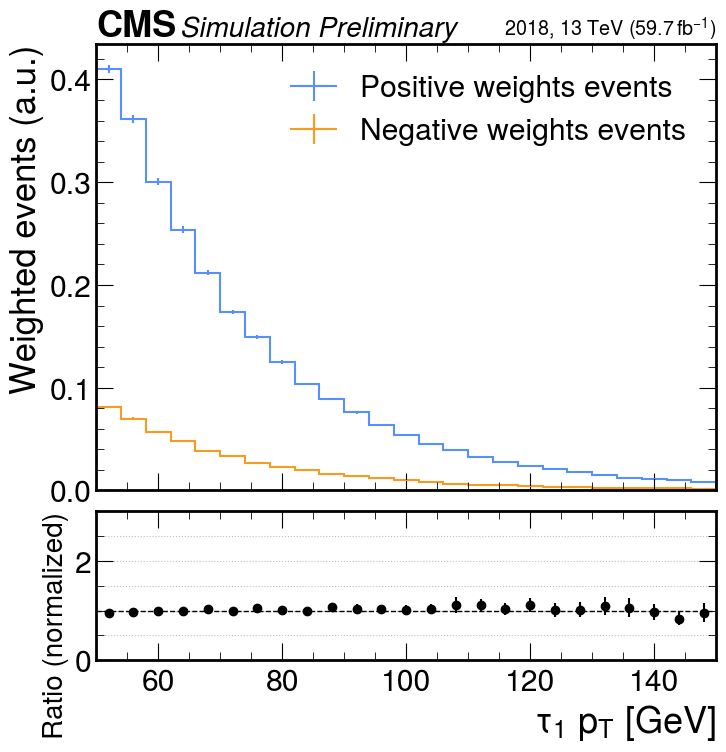

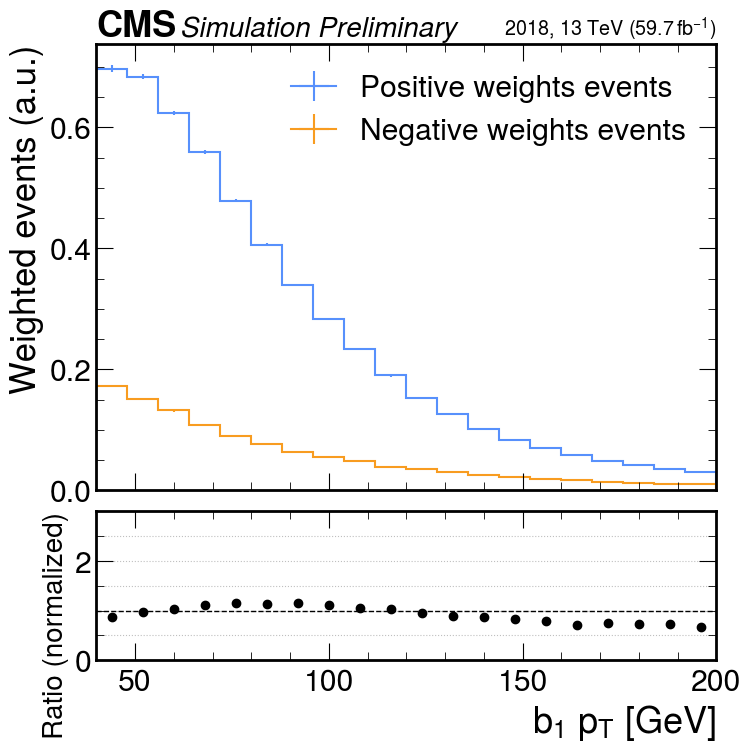

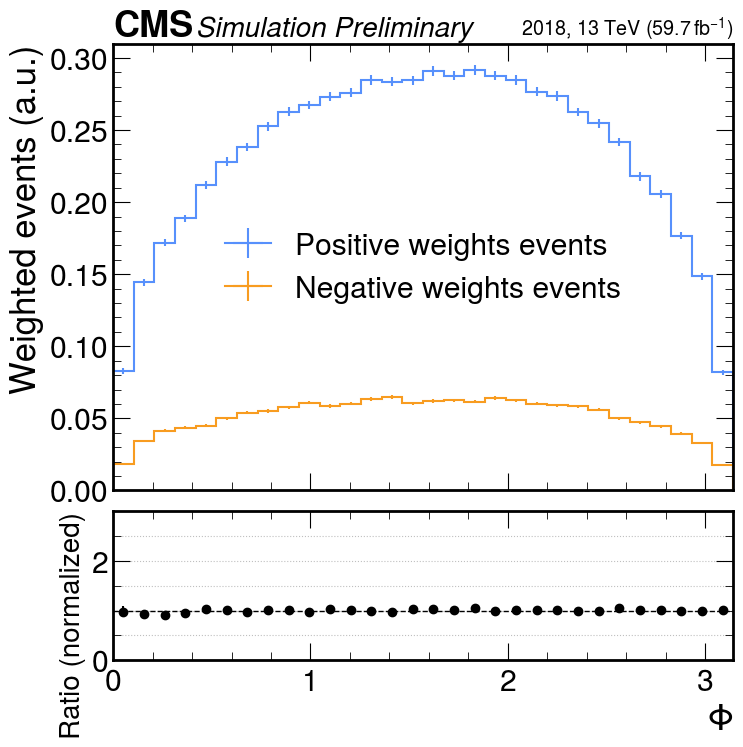

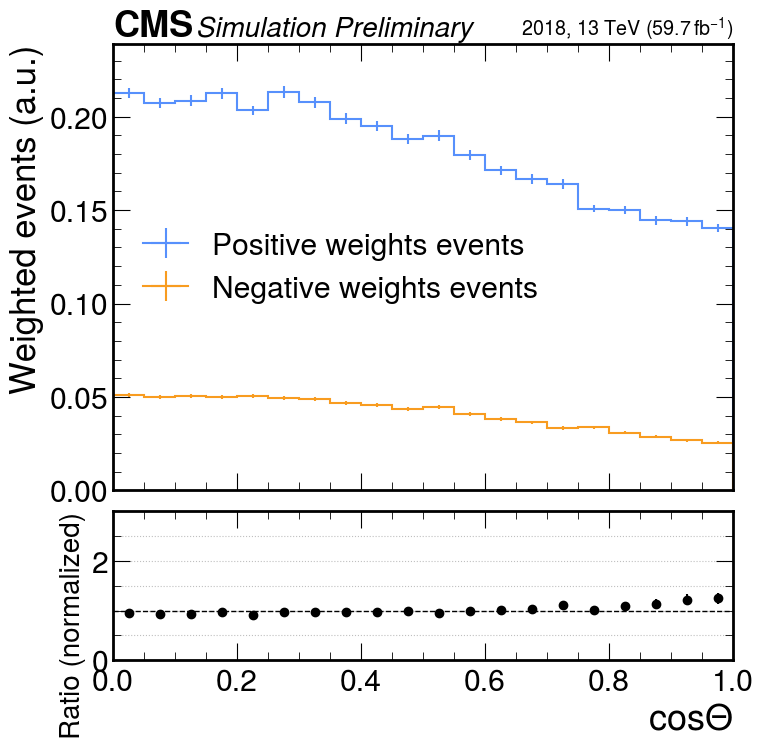

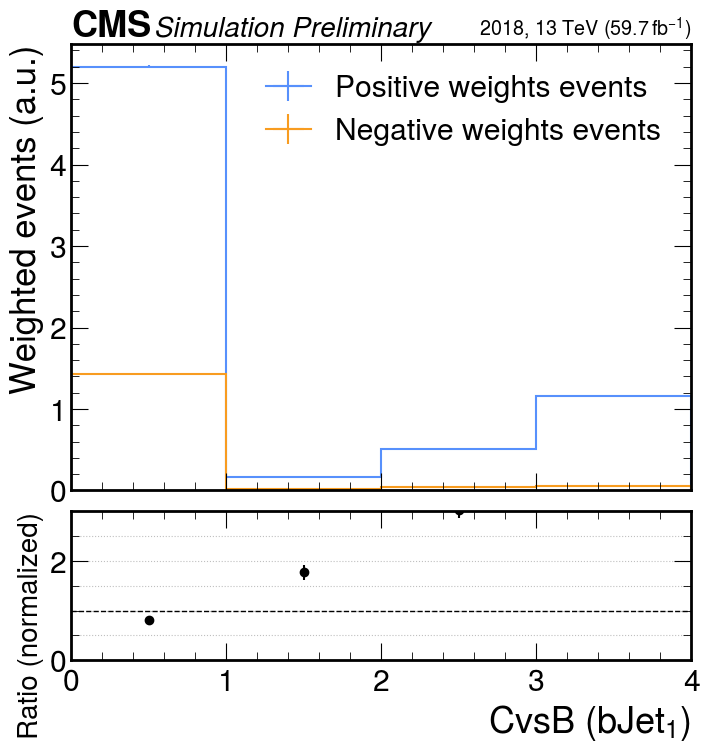

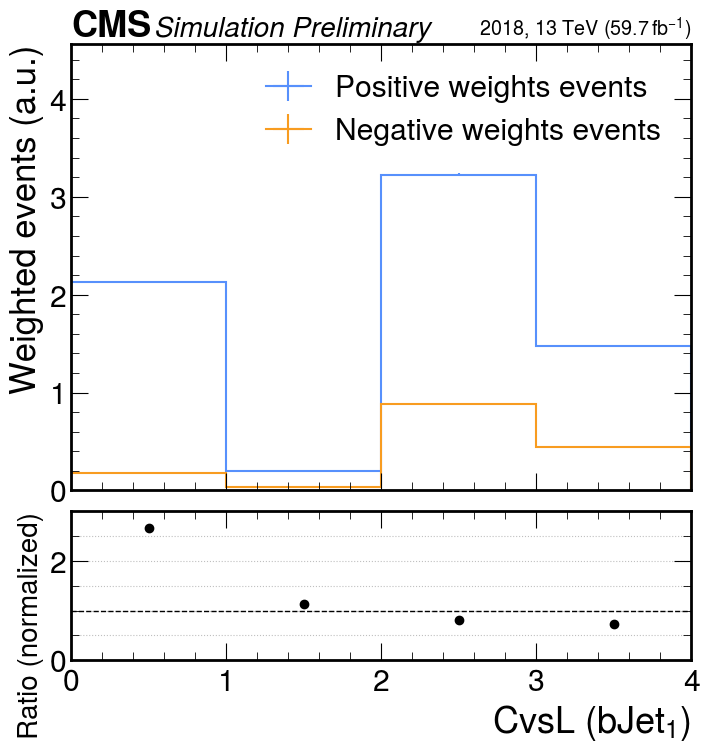

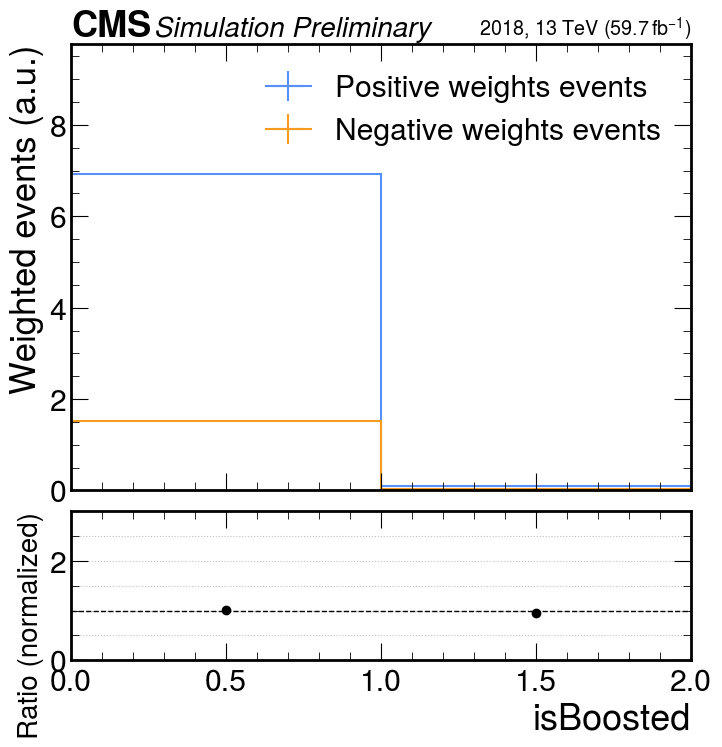

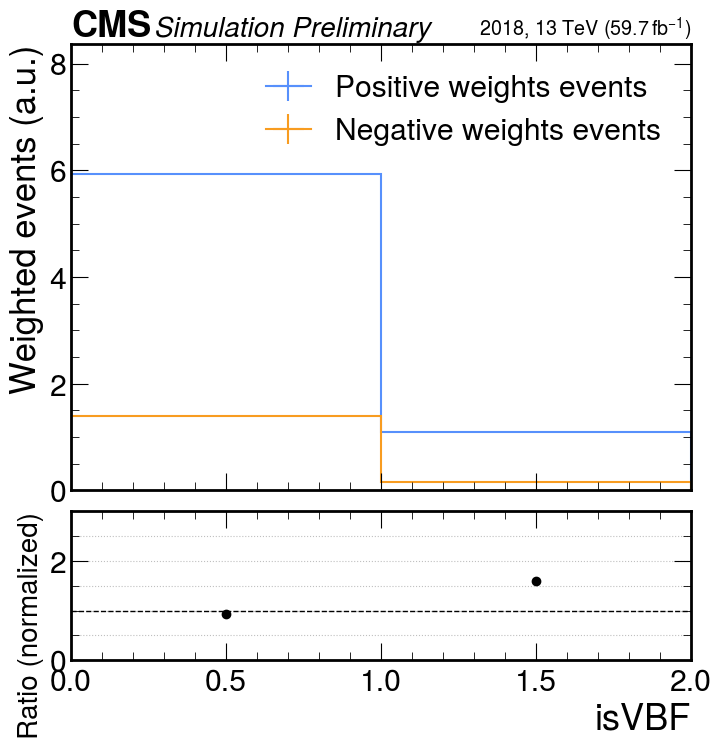

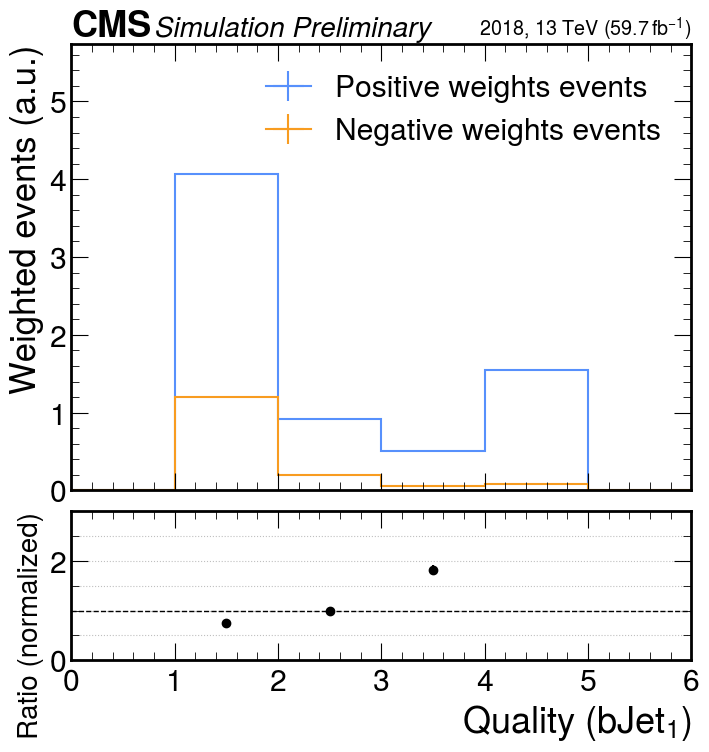

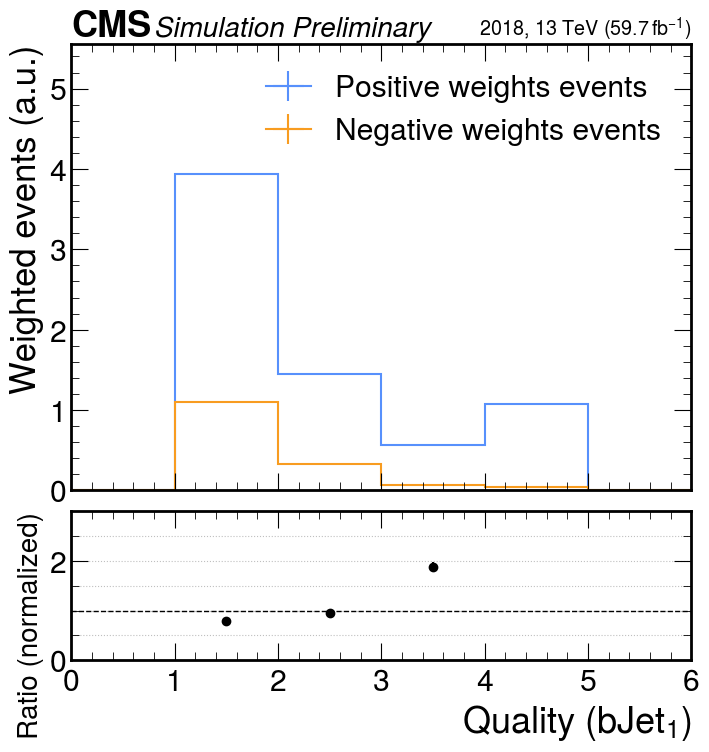

In [50]:
vars = {"hh_kinfit_chi2": [(30, 0, 50), r"ZZ $\chi^{2}$ (Kin. Fit)"],
        "hh_kinfit_m": [(50, 0, 1000), r"ZZ mass (Kin. Fit) [GeV]"],
        "sv_mass": [(20, 30, 230), r"Z($\tau^{+}\tau^{-})$ mass (SVFit) [GeV]"],
        "dR_l1_l2_x_sv_pT": [(30, 0, 400), r"$\Delta R$ $(l_{1}, l_{2})$ $\times$ $p_{T}$ $(Z_{\tau\tau}^{SVFit})$"],
        "l_1_mt": [(25, 0, 200), r"$m_{T}$ $(l_{1})$ [GeV]"],
        "l_2_pT": [(25, 50, 150), r"$\tau_{2}$ $p_{t}$ [GeV]"],
        "dR_l1_l2": [(50, 0, 5), r"$\Delta R$ $(l_{1}, l_{2})$"],
        "dphi_sv_met": [(30, 0, 3.14), r"$\Delta\phi$ $(Z_{\tau\tau}^{SVFit}, MET)$"], 
        "h_bb_mass": [(35, 0, 350), r"$Z(b\bar{b})$ mass [GeV]"],
        "b_2_hhbtag": [(50, 0, 1), r"ZZbtag $bJet_{2}$"],
        "diH_mass_sv": [(50, 0, 1000), r"$ZZ_{bb\tau\tau}^{SVFit}$ [GeV]"],
        "dphi_hbb_sv": [(30, 0, 3.14), r"$\Delta\phi$ $(Z_{bb}, Z_{\tau\tau}^{SVFit})$"],
        "h_bb_pT": [(10, 50, 150), r"$Z(b\bar{b})$ $p_{T}$ [GeV]"],
        "dR_l1_l2_boosted_htt_met": [(50, 0, 5), r"$\Delta R$ $(l_{1}, l_{2})$ Boost($Z_{\tau\tau}+MET$)"], 
        "l_1_pT": [(25, 50, 150), r"$\tau_{1}$ $p_{T}$ [GeV]"],
        "b_1_pT": [(20, 40, 200), r"$b_{1}$ $p_{T}$ [GeV]"],
        "phi": [(30, 0, 3.14), r"$\Phi$"], 
        "costheta_l2_httmet": [(20, 0, 1), r"$cos\Theta$"],
        "b_1_cvsb": [(4, 0, 4), r"CvsB $(bJet_{1})$"],
        "b_1_cvsl": [(4, 0, 4), r"CvsL $(bJet_{1})$"],
        "boosted": [(2, 0, 2), r"isBoosted"], 
        "is_vbf": [(2, 0, 2), r"isVBF"], 
        "jet_1_quality": [(6, 0, 6), r"Quality $(bJet_{1})$"], 
        "jet_2_quality": [(6, 0, 6), r"Quality $(bJet_{1})$"],
}
### backgrounds
for var in vars.keys():
    #print(var)
    axis = hist.axis.Regular(*vars[var][0], name=var, label=vars[var][1])

    fig = plt.figure(figsize=(8,8))
    grid = fig.add_gridspec(2, 1, hspace=0.07, height_ratios=[3, 1])

    main_ax:plt.Axes = fig.add_subplot(grid[0])
    subplot_ax:plt.Axes = fig.add_subplot(grid[1], sharex=main_ax)

    pos_h = hist.Hist(axis, storage=hist.storage.Weight()).fill(df_bkg_pos[var], weight=df_bkg_pos["weight"])
    neg_h = hist.Hist(axis, storage=hist.storage.Weight()).fill(df_bkg_neg[var], weight=np.abs(df_bkg_neg["weight"]))
    hep.histplot([pos_h, neg_h],
                label=["Positive weights events", "Negative weights events"], ax=main_ax, flow="none")
    main_ax.legend()
    
    np.seterr(divide='ignore')
    ratio = unumpy.uarray(pos_h.values(), np.sqrt(pos_h.variances())) / unumpy.uarray(neg_h.values()+sys.float_info.epsilon, np.sqrt(pos_h.variances())) * neg_h.sum().value / pos_h.sum().value #pos_h.values() / neg_h.values() * neg_h.sum().value / pos_h.sum().value
    # uncertainty = np.sqrt((1/pos_h.values() + 1/neg_h.values()) * ((pos_h.values() / neg_h.values()) ** 2))
    hist.plot.plot_ratio_array(pos_h, unumpy.nominal_values(ratio), unumpy.std_devs(ratio), subplot_ax, ylim=(0.,3.), markersize=5)

    subplot_ax.set_ylim(0., 3.)
    plt.setp(main_ax.get_xticklabels(), visible=False)
    main_ax.set_xlabel("")
    subplot_ax.set_xlabel(vars[var][1])
    subplot_ax.grid(axis="y", which="both")
    subplot_ax.set_ylabel("Ratio (normalized)", size=20)
    main_ax.set_ylabel("Weighted events (a.u.)", size=25)
    hep.cms.text("Simulation Preliminary", fontsize=20, ax=main_ax)
    lumi = 59741
    hep.cms.lumitext(f"2018, 13 TeV (${lumi/ 1000:.1f}\/""fb^{-1}$)", fontsize=15, ax=main_ax)

    hep.plot.yscale_legend(main_ax)
    plt.savefig(f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/NicePlots/dnn/input_negativeWeights/2018/background_{var}.pdf")

/tmp/ipykernel_233347/3716084582.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8,8))


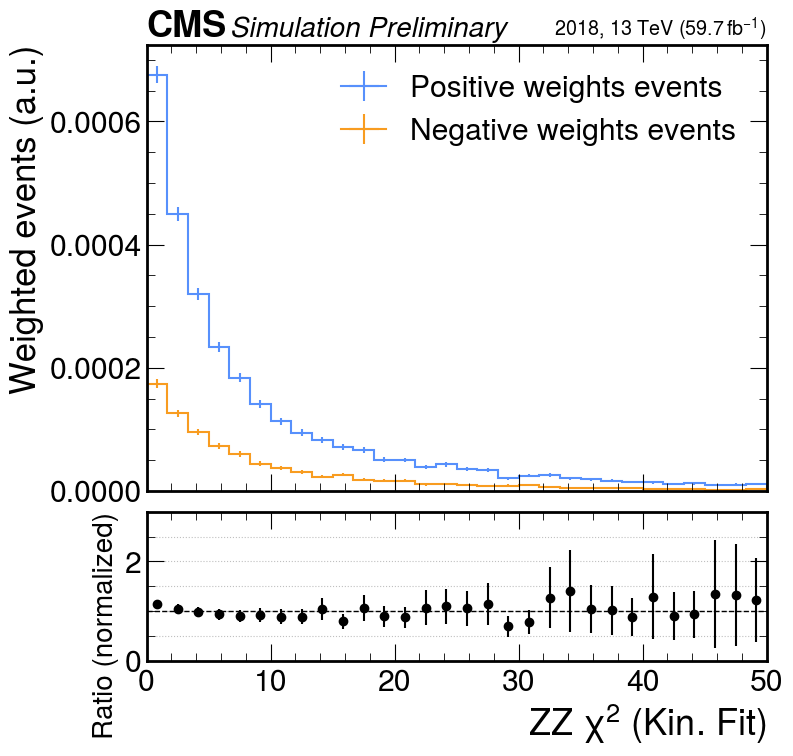

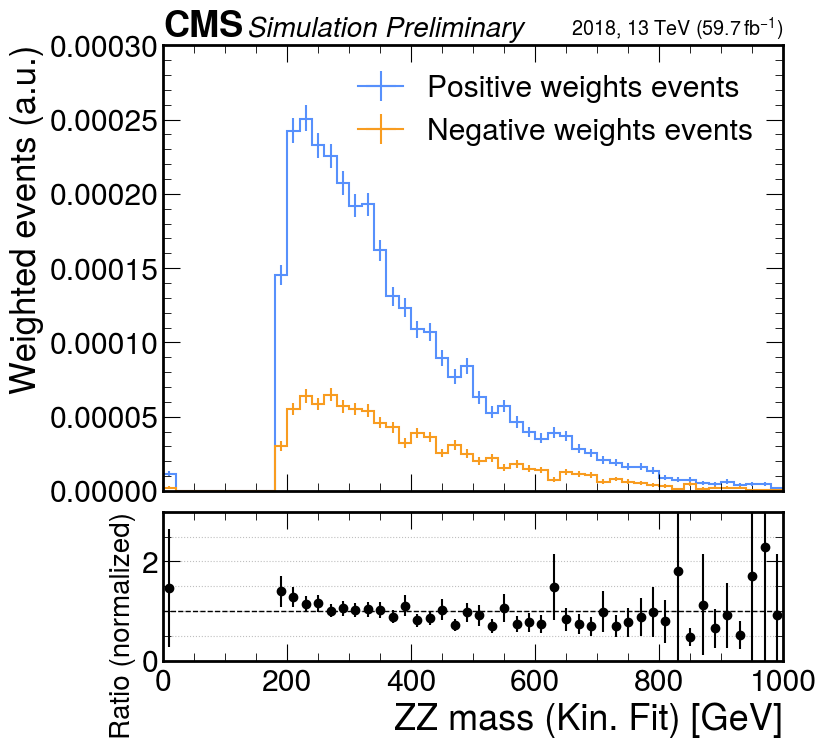

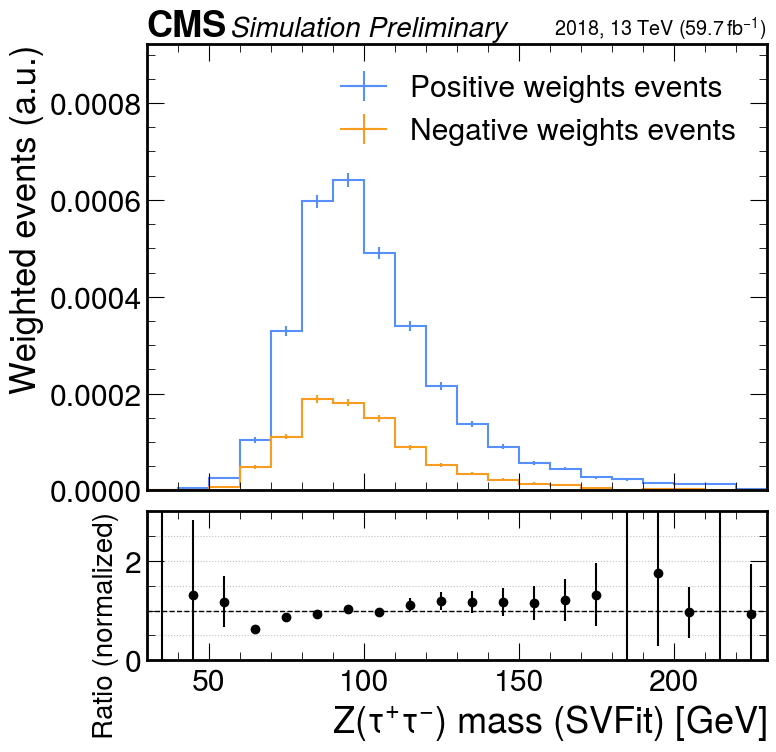

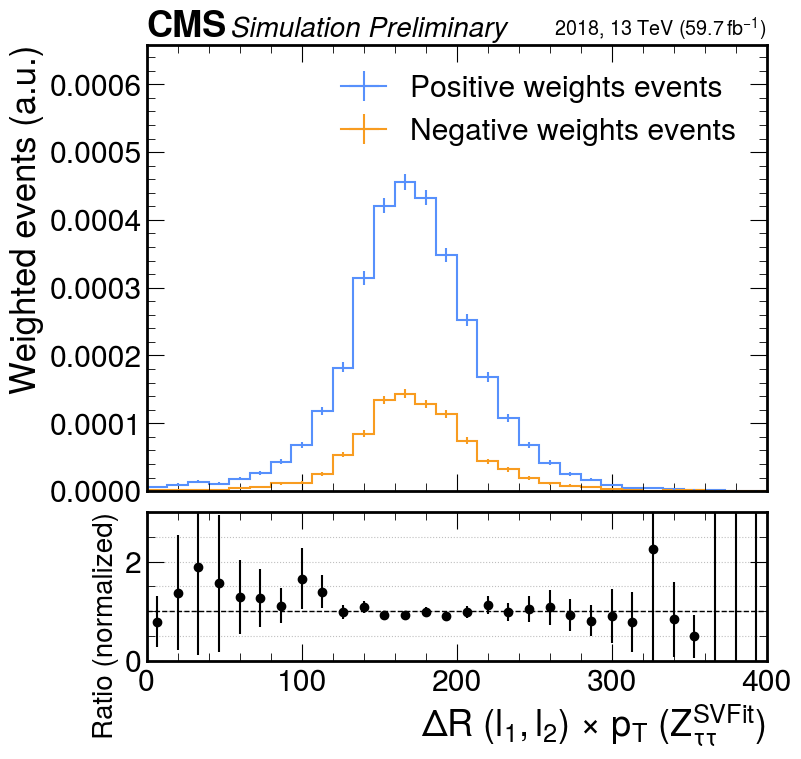

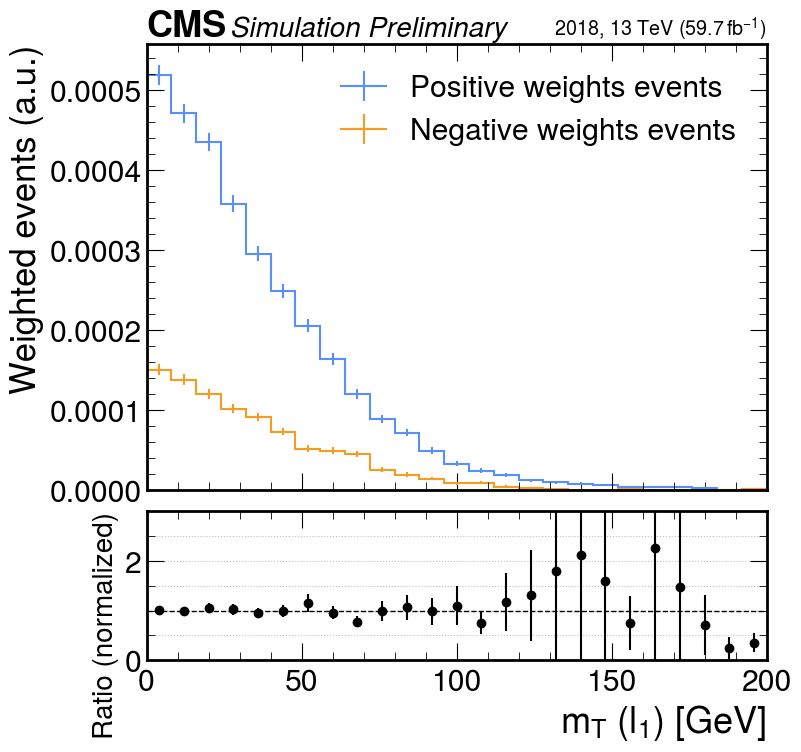

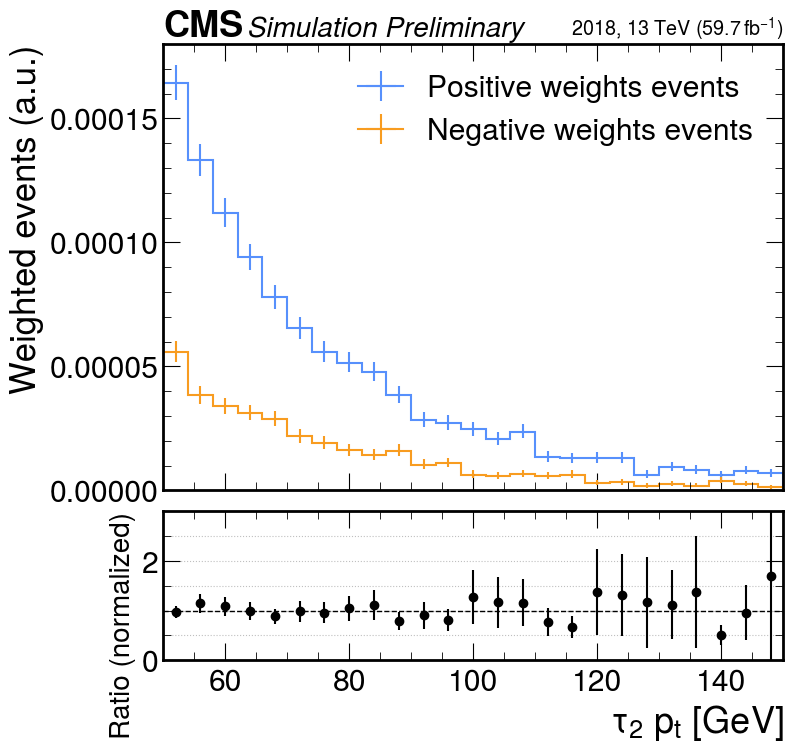

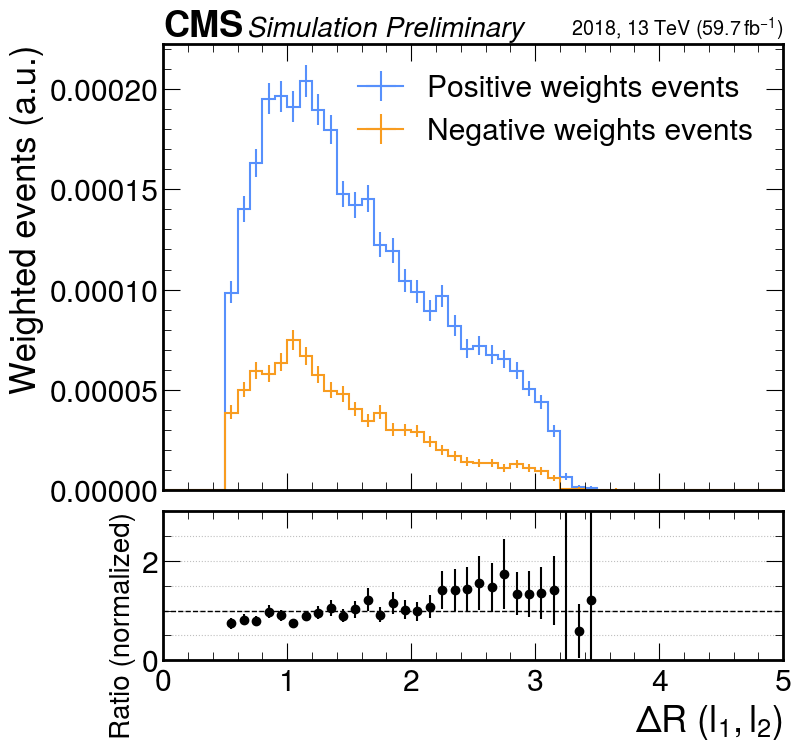

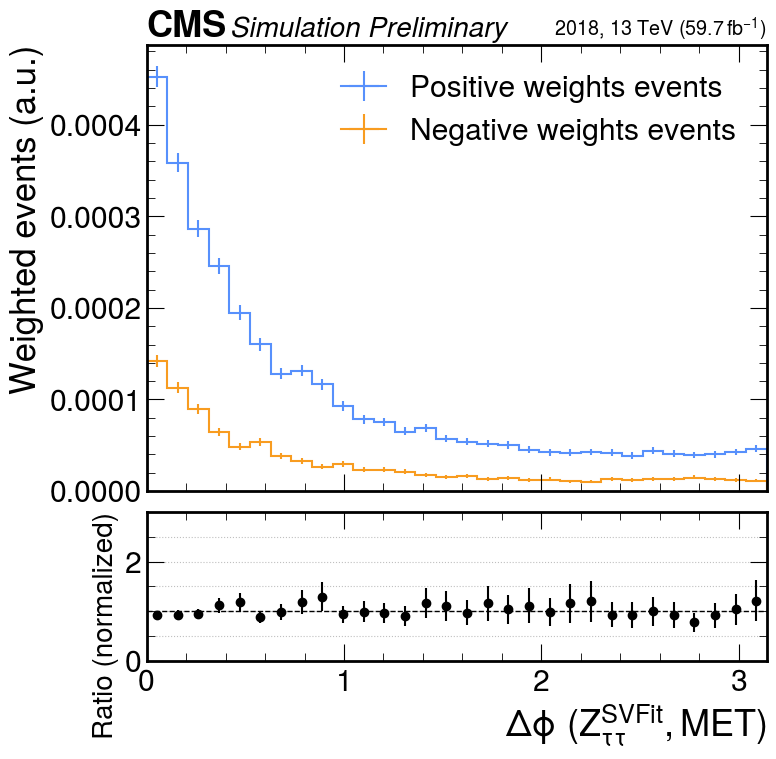

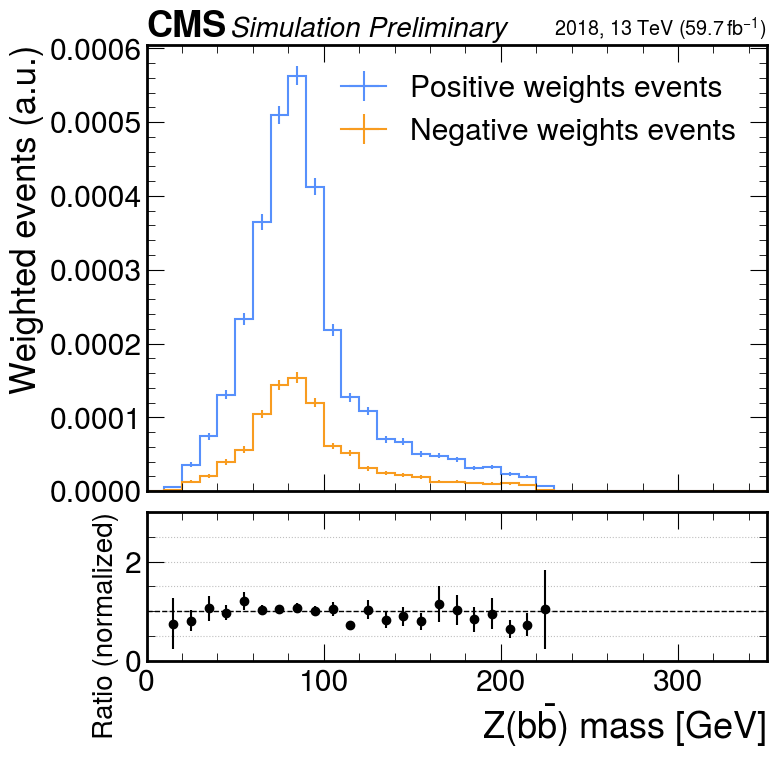

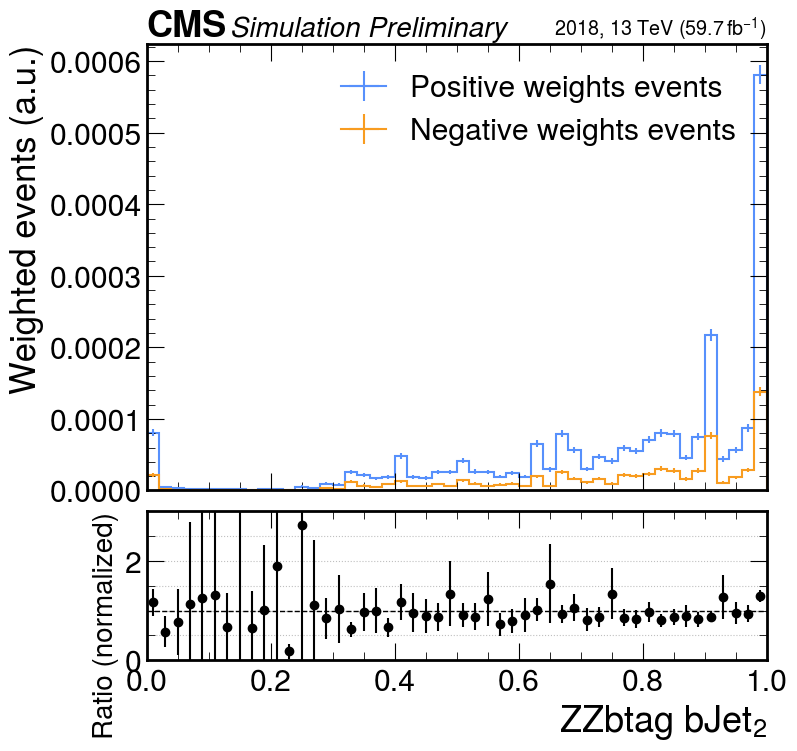

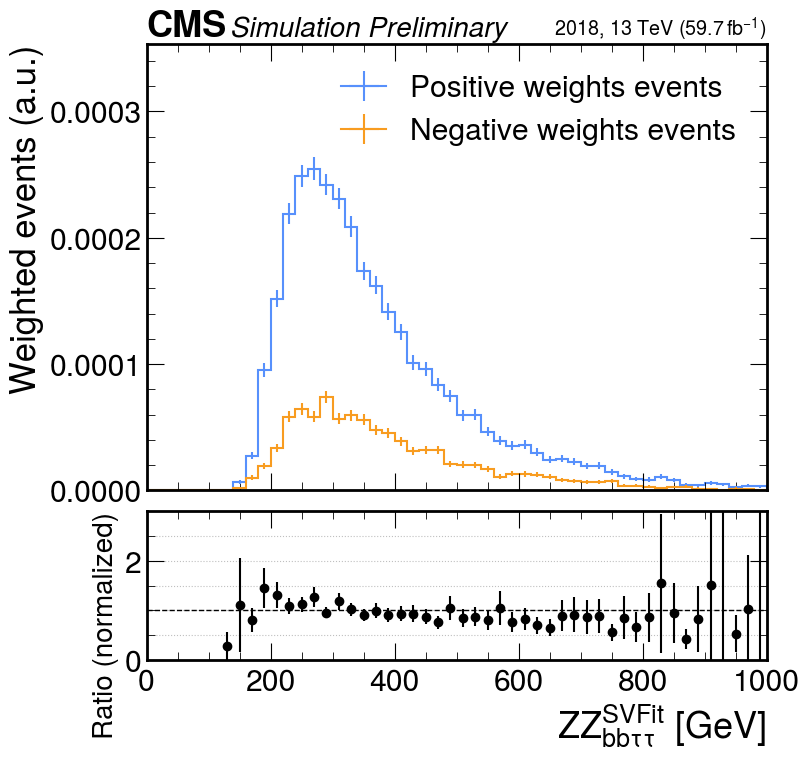

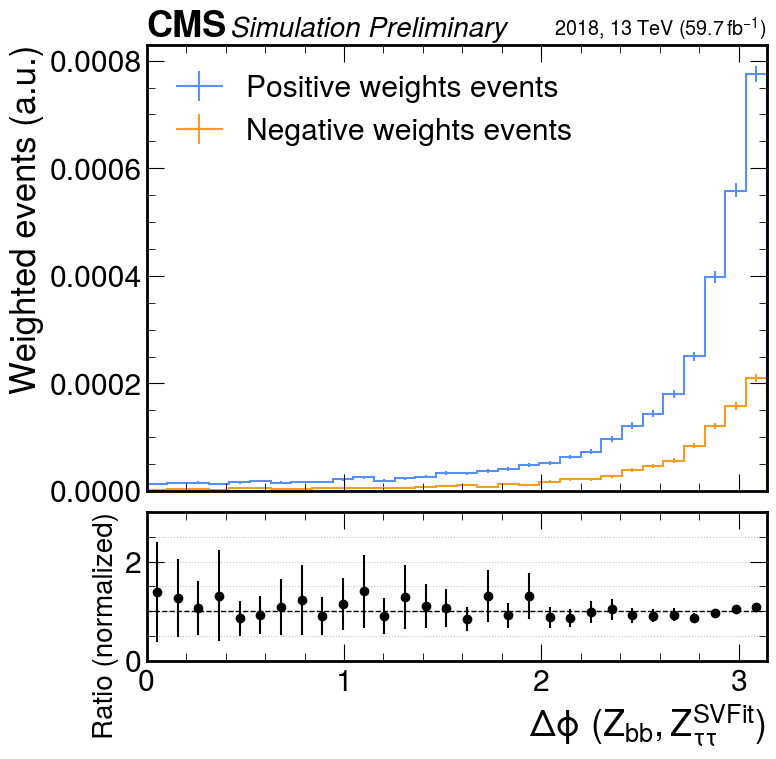

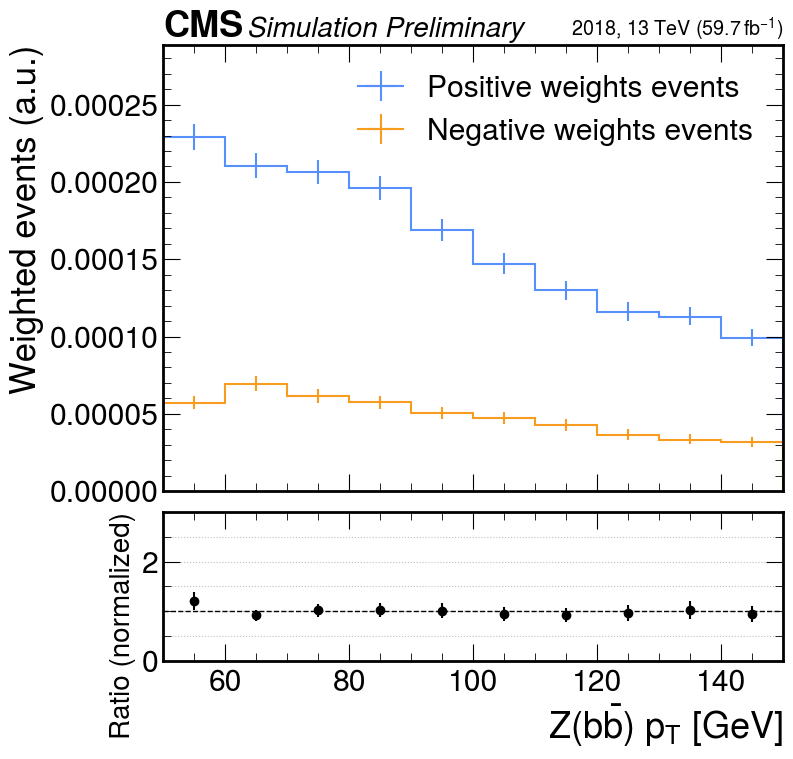

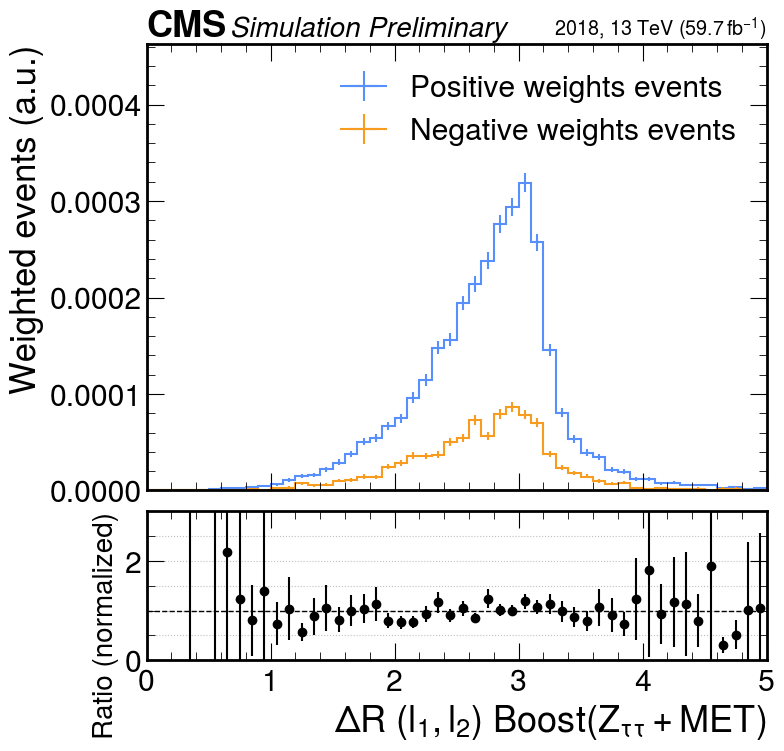

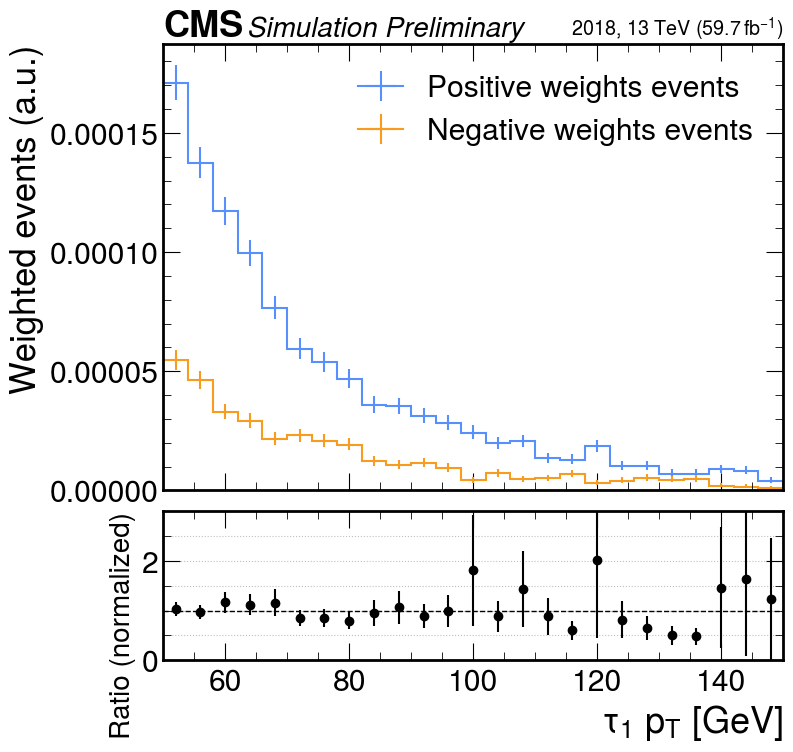

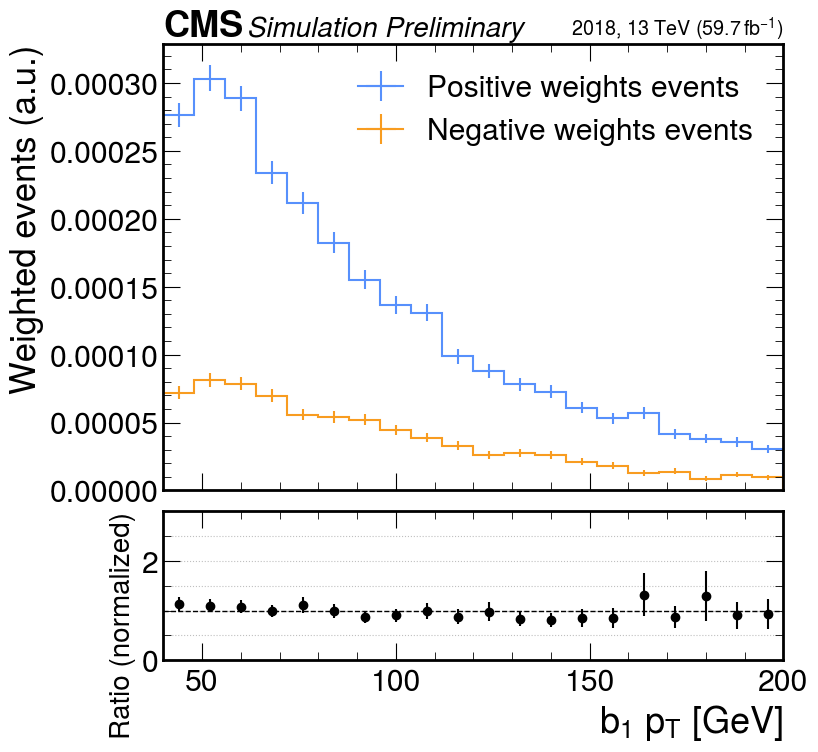

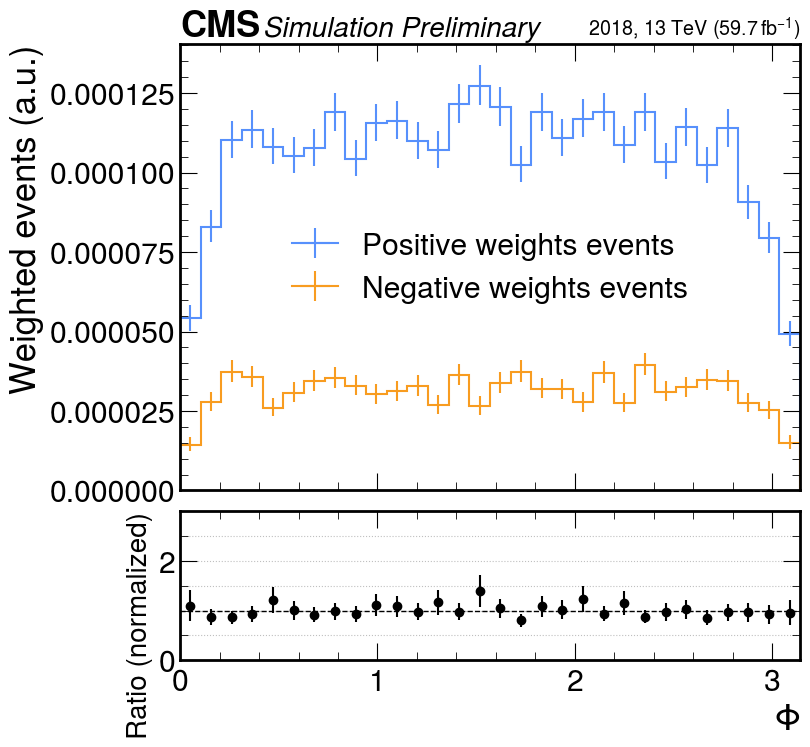

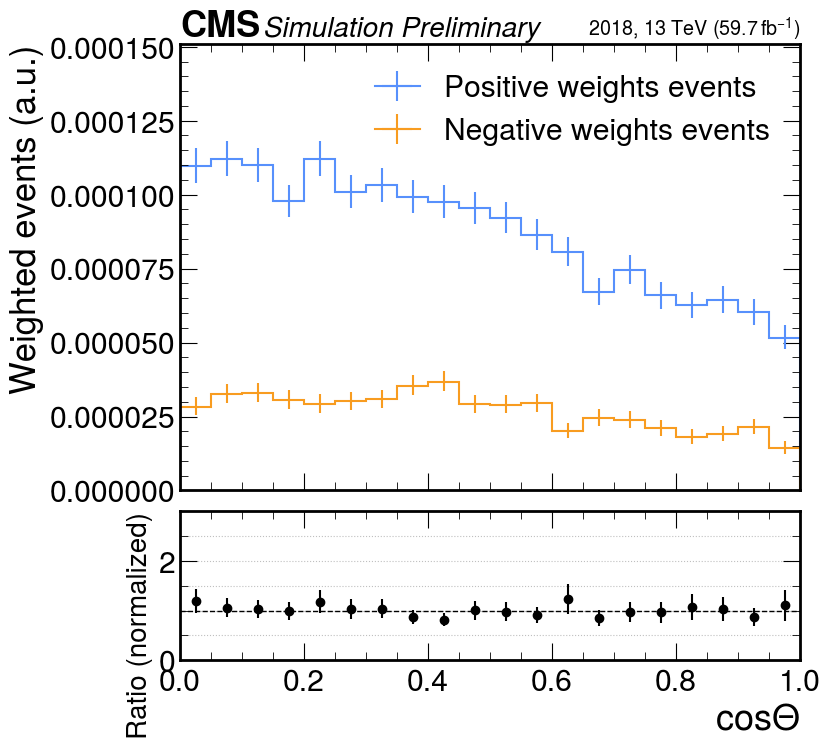

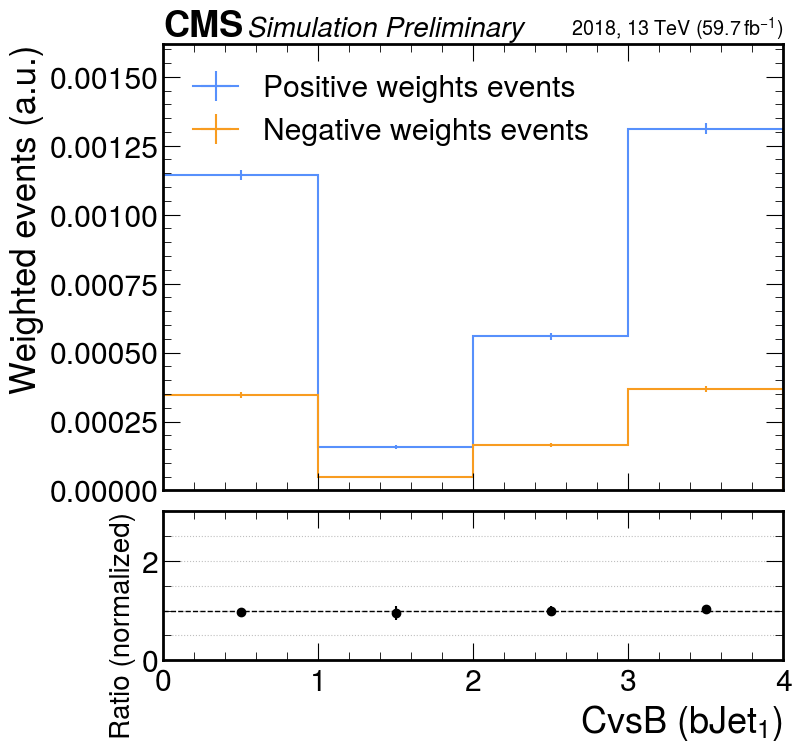

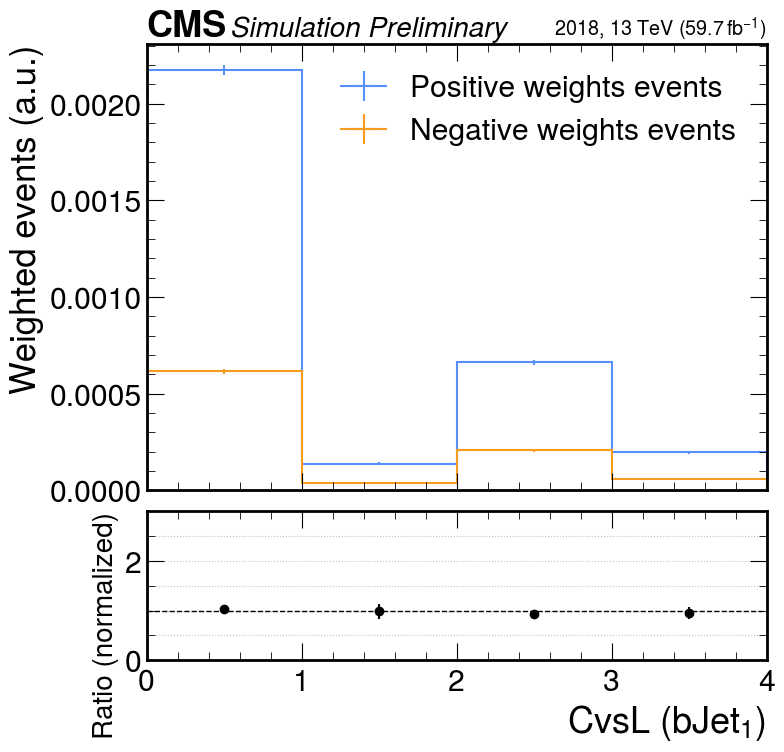

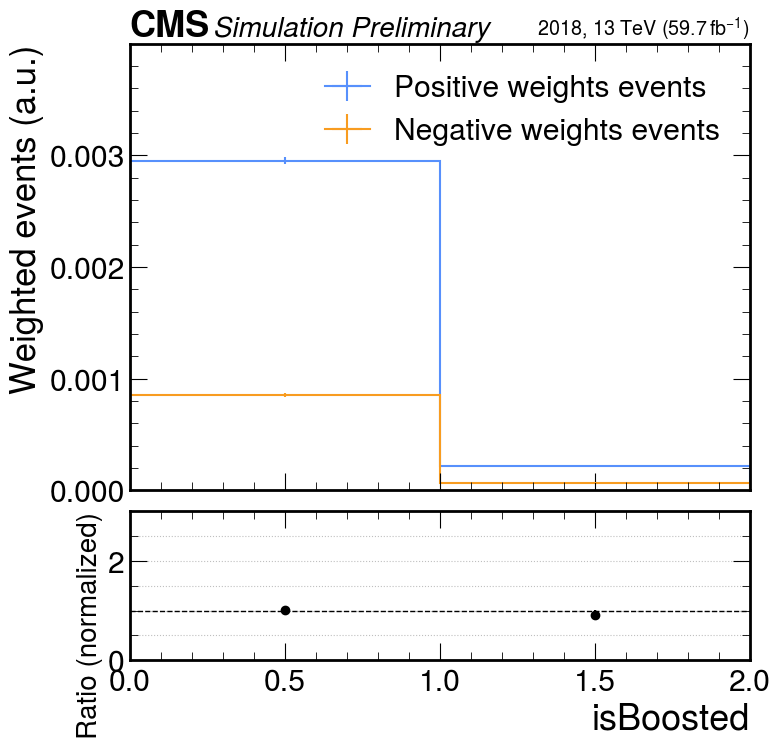

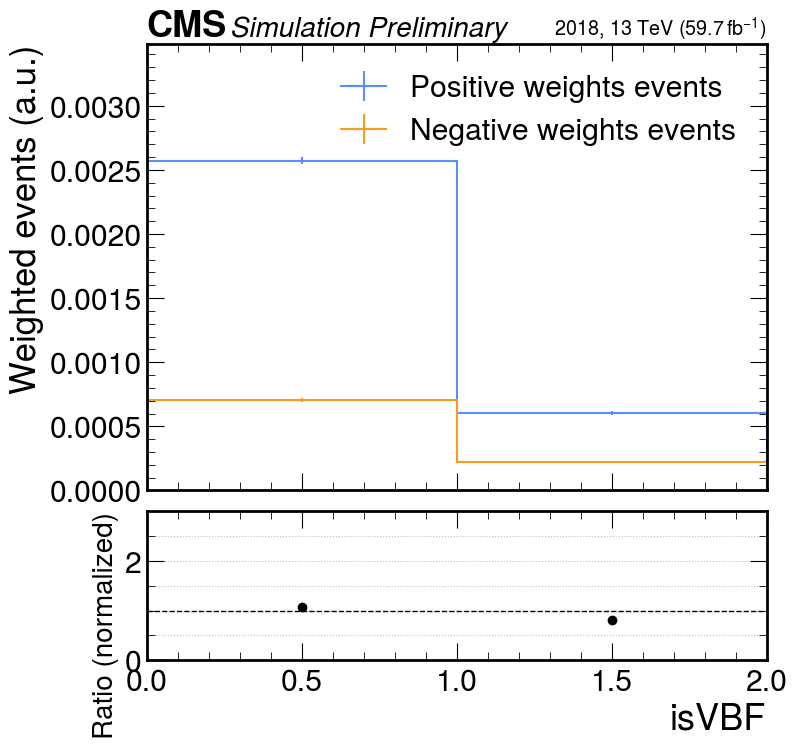

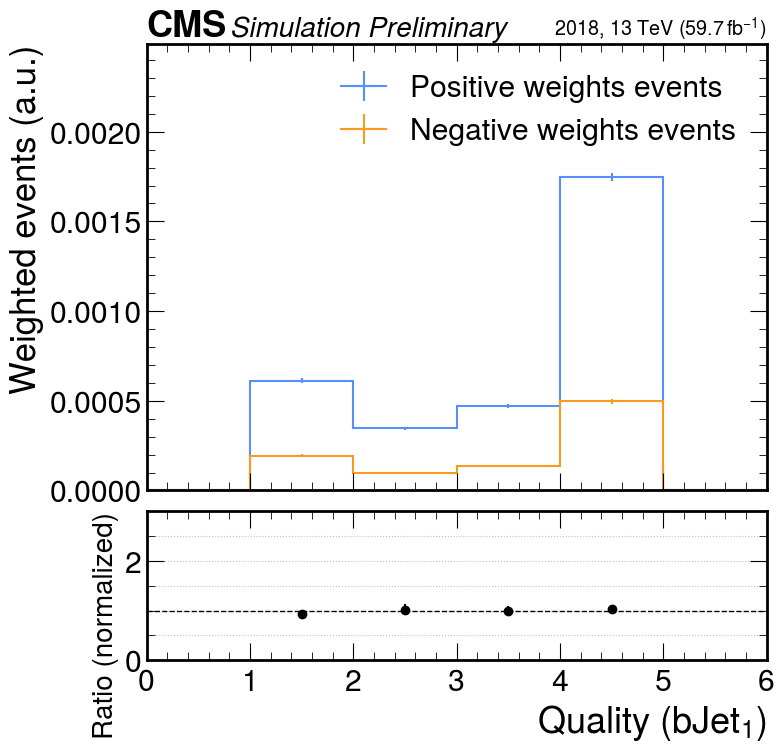

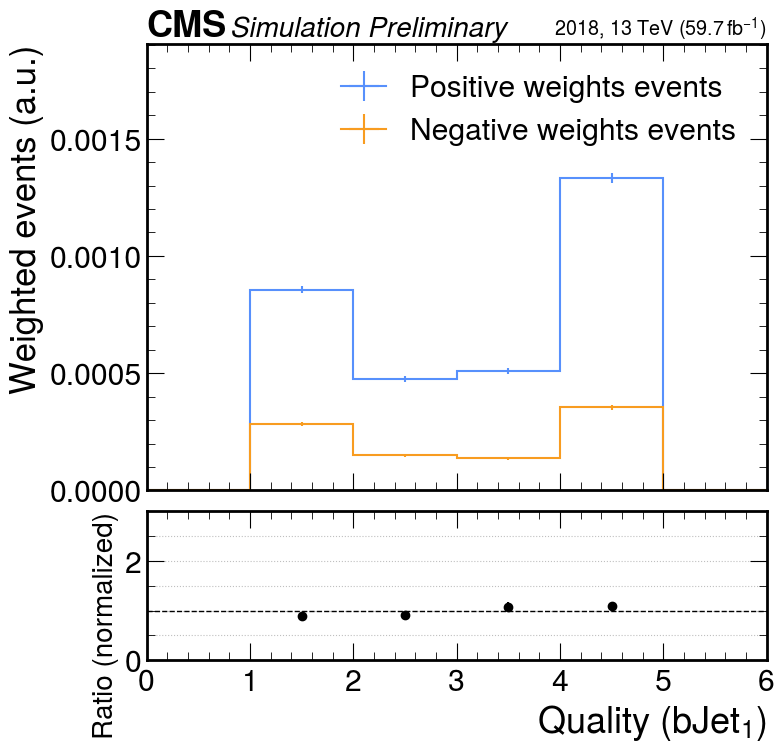

In [49]:
for var in vars.keys():
    #print(var)
    axis = hist.axis.Regular(*vars[var][0], name=var, label=vars[var][1])

    fig = plt.figure(figsize=(8,8))
    grid = fig.add_gridspec(2, 1, hspace=0.07, height_ratios=[3, 1])

    main_ax:plt.Axes = fig.add_subplot(grid[0])
    subplot_ax:plt.Axes = fig.add_subplot(grid[1], sharex=main_ax)

    pos_h = hist.Hist(axis, storage=hist.storage.Weight()).fill(df_sig_pos[var], weight=df_sig_pos["weight"])
    neg_h = hist.Hist(axis, storage=hist.storage.Weight()).fill(df_sig_neg[var], weight=np.abs(df_sig_neg["weight"]))
    hep.histplot([pos_h, neg_h],
                label=["Positive weights events", "Negative weights events"], ax=main_ax, flow="none")
    main_ax.legend()
    
    np.seterr(divide='ignore')
    ratio = unumpy.uarray(pos_h.values(), np.sqrt(pos_h.variances())) / unumpy.uarray(neg_h.values()+sys.float_info.epsilon, np.sqrt(pos_h.variances())) * neg_h.sum().value / pos_h.sum().value #pos_h.values() / neg_h.values() * neg_h.sum().value / pos_h.sum().value
    # uncertainty = np.sqrt((1/pos_h.values() + 1/neg_h.values()) * ((pos_h.values() / neg_h.values()) ** 2))
    hist.plot.plot_ratio_array(pos_h, unumpy.nominal_values(ratio), unumpy.std_devs(ratio), subplot_ax, ylim=(0.,3.), markersize=5)

    subplot_ax.set_ylim(0., 3.)
    plt.setp(main_ax.get_xticklabels(), visible=False)
    main_ax.set_xlabel("")
    subplot_ax.set_xlabel(vars[var][1])
    subplot_ax.grid(axis="y", which="both")
    subplot_ax.set_ylabel("Ratio (normalized)", size=20)
    main_ax.set_ylabel("Weighted events (a.u.)", size=25)
    hep.cms.text("Simulation Preliminary", fontsize=20, ax=main_ax)
    lumi = 59741
    hep.cms.lumitext(f"2018, 13 TeV (${lumi/ 1000:.1f}\/""fb^{-1}$)", fontsize=15, ax=main_ax)

    hep.plot.yscale_legend(main_ax)
    plt.savefig(f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/NicePlots/dnn/input_negativeWeights/2018/signal_{var}.pdf")